# 쇼핑몰 리뷰 분석
- 평점 4,5점 - 1
- 평점 1,2점 - 0

In [1]:
# Colab에 Mecab(형태소 분석기) 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1231 sha256=4cacafab3898f57e8bba83ea786cae52ab79dce070054527dc67b9693d9fccce
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1381k  100 1381k    0     0   406k      0  0:00:03  0:00:03 --:--:--  649k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Load

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7d8bb70d8580>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews']) # 열제목 추가
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# preprocessing

In [6]:
# label 생성
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
# 결측치 확인
print(total_data.isnull().values.any())

False


In [10]:
# train / test 분리 3:1
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


<Axes: >

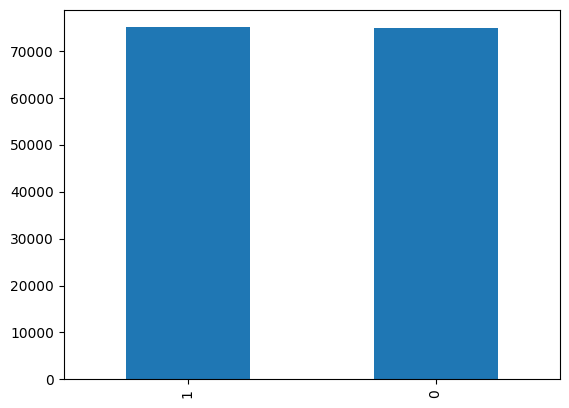

In [11]:
# 레이블 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-13-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [14]:
# 테스트 데이터 전처리
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-14-6b01323717e8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


# Tokenizer

In [15]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# 단어와 길이 분포 확인

In [18]:
# 긍정/부정 리뷰 확인
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [19]:
# 각 단어의 빈도수 확인
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20)) # 부정 리뷰의 자주 쓰인 단어 상위 20

[('네요', 31802), ('는데', 20197), ('안', 19719), ('어요', 14838), ('있', 13200), ('너무', 13057), ('했', 11766), ('좋', 9803), ('배송', 9677), ('같', 8997), ('어', 8929), ('구매', 8869), ('거', 8861), ('없', 8672), ('아요', 8640), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7985)]


In [20]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20)) # 긍정 리뷰의 자주 쓰인 단어 상위 20

[('좋', 39422), ('아요', 21186), ('네요', 19894), ('어요', 18673), ('잘', 18603), ('구매', 16165), ('습니다', 13320), ('있', 12391), ('배송', 12274), ('는데', 11635), ('합니다', 9801), ('했', 9783), ('먹', 9640), ('재', 9274), ('너무', 8398), ('같', 7867), ('만족', 7259), ('거', 6484), ('어', 6330), ('쓰', 6291)]


긍정 리뷰의 평균 길이 : 13.579646194659592
부정 리뷰의 평균 길이 : 17.031514455805013


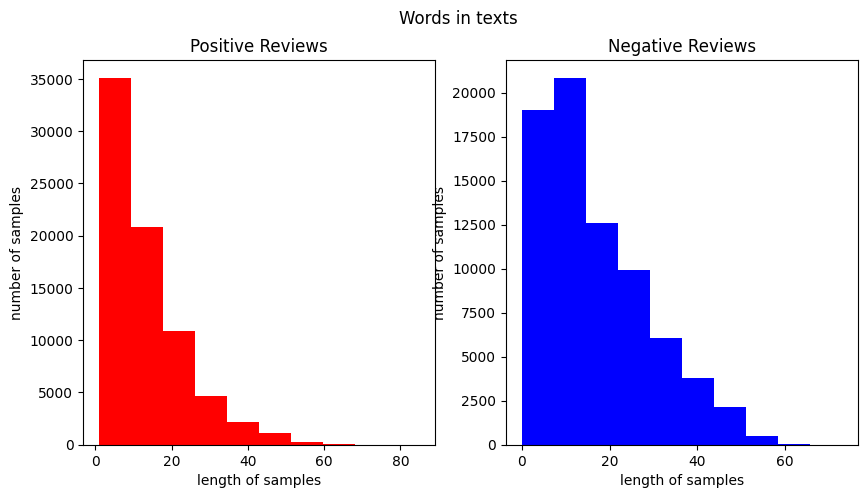

In [21]:
# 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

**부정 리뷰가 더 길다**

In [22]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

# 정수 인코딩

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## 등장 횟수가 1인 단어 배제

In [24]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40126
등장 빈도가 1번 이하인 희귀 단어의 수: 18274
단어 집합에서 희귀 단어의 비율: 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.796385627754


In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21854


In [26]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[:3])

[[67, 2060, 300, 14295, 263, 73, 6, 237, 168, 136, 801, 2940, 626, 2, 76, 62, 207, 40, 1344, 155, 3, 6], [482, 400, 52, 8525, 2592, 2450, 338, 2941, 251, 2351, 39, 473, 2], [45, 24, 832, 104, 35, 2366, 160, 7, 10, 8058, 4, 1319, 30, 138, 323, 44, 59, 160, 138, 7, 1916, 2, 113, 163, 1385, 307, 119, 135]]


In [28]:
print(X_test[:3])

[[14, 704, 767, 115, 186, 252, 12], [338, 3907, 62, 3819, 1624], [11, 69, 2, 49, 164, 3, 27, 15, 6, 514, 289, 17, 92, 110, 584, 59, 7, 2]]


# 패딩
- 길이 맞추기

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.304486730562726


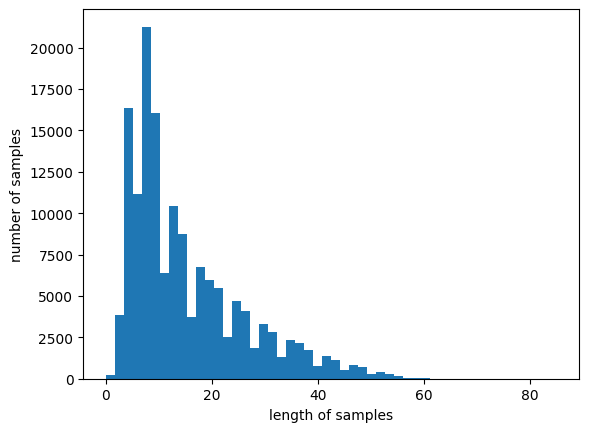

In [29]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
# 최적의 max_len 값 찾기
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [31]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [32]:
# 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU 네이버 쇼핑 리뷰 분류

In [33]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2943 - acc: 0.8866
Epoch 1: val_acc improved from -inf to 0.90929, saving model to best_model.h5
1875/1875 [==============================] - 48s 22ms/step - loss: 0.2943 - acc: 0.8866 - val_loss: 0.2492 - val_acc: 0.9093
Epoch 2/15
  15/1875 [..............................] - ETA: 13s - loss: 0.2596 - acc: 0.9167

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - ETA: 0s - loss: 0.2286 - acc: 0.9179
Epoch 2: val_acc improved from 0.90929 to 0.91823, saving model to best_model.h5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2286 - acc: 0.9179 - val_loss: 0.2233 - val_acc: 0.9182
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2074 - acc: 0.9259
Epoch 3: val_acc improved from 0.91823 to 0.92023, saving model to best_model.h5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2074 - acc: 0.9259 - val_loss: 0.2193 - val_acc: 0.9202
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1931 - acc: 0.9324
Epoch 4: val_acc improved from 0.92023 to 0.92397, saving model to best_model.h5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1931 - acc: 0.9324 - val_loss: 0.2124 - val_acc: 0.9240
Epoch 5/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1811 - acc: 0.9377
Epoch 5: val_acc did no

In [34]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 8s 5ms/step - loss: 0.2176 - acc: 0.9228

 테스트 정확도: 0.9228


# 리뷰 예측하기

In [35]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [36]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 322ms/step
97.72% 확률로 긍정 리뷰입니다.


In [37]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 17ms/step
99.56% 확률로 부정 리뷰입니다.


In [38]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 [==============================] - 0s 18ms/step
97.89% 확률로 긍정 리뷰입니다.


In [39]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 [==============================] - 0s 20ms/step
92.76% 확률로 부정 리뷰입니다.
